# Demo of the GMM in ischemic stroke 

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage import measure
from skimage.morphology import remove_small_objects, binary_closing, ball
from brukerapi.dataset import Dataset
import scipy.io
from scipy.stats import norm
import pyvista as pv

In [3]:
# Read diffusion image
data_path = '/Users/kamil/Documents/my_softwares/gmm_stroke/data/rat_model_1/6/pdata/1/2dseq/'
dataset = Dataset(data_path)
img = dataset.data.squeeze() # [x, y, z, b]
img = np.rot90(np.transpose(img, (1, 0, 2, 3)), 2)

# Read diffusion mask (created in matlab)
brain_mask = scipy.io.loadmat('/Users/kamil/Documents/my_softwares/gmm_stroke/data/brain_mask.mat')['brain_mask']

# Read b-values from PV360 software
dataset.add_parameter_file('method')
bvals = dataset['PVM_DwEffBval'].value

In [4]:
# Extract brain tissue using mask
brain_mask_4d = brain_mask[..., np.newaxis] # [x, y, z, 1]
diff_img = img * brain_mask_4d

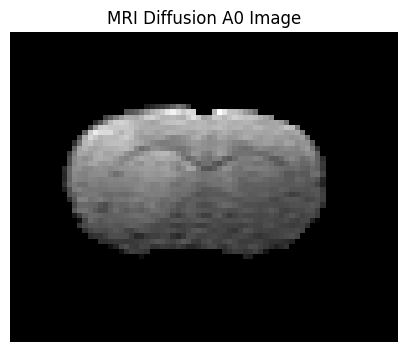

In [5]:
# Show diffusion image
plt.figure(figsize = (5, 5))
plt.imshow(diff_img[:, :, 22, 0], 
           cmap = 'gray')
plt.title(f'MRI Diffusion A0 Image')
plt.axis('off')
plt.show();

In [6]:
# Create function to calculate ADCmap
def compute_adc(diff_img, bvals, brain_mask):
    '''
    Compute the Apparent Diffusion Coefficient (ADC) map from diffusion-weighted imaging data.
    
    Args:
        diff_img (numpy.ndarray): 4D array of diffusion-weighted images with shape (x, y, z, b)
        bvals (numpy.ndarray): 1D array of b-values 
        brain_mask (numpy.ndarray): 3D binary mask indicating brain tissue with shape (x, y, z)
    Returns:
        numpy.ndarray: 3D array representing the ADC map with shape (x, y, z)
    '''

    mask_bool = brain_mask.astype(bool)

    shape = diff_img.shape
    n_vox = np.prod(shape[:3])
    n_b = shape[3]

    data_2d = diff_img.reshape(n_vox, n_b)
    log_data = np.zeros_like(data_2d, dtype=np.float32)
    
    data_2d[data_2d <= 0] = np.nan
    log_data = np.log(data_2d)

    # Line fitting S = S0 * exp(-b * ADC) => log(S) = log(S0) - b*ADC
    ADC_map_flat = np.zeros(n_vox, dtype=np.float32)

    for idx in range(n_vox):
        if not mask_bool.reshape(-1)[idx]:
            continue
        y = log_data[idx, :]
        if np.any(np.isnan(y)):
            continue
        p = np.polyfit(bvals, y, 1)
        slope = p[0] 
        ADC_map_flat[idx] = -slope  # ADC = -slope

    ADC_map = ADC_map_flat.reshape(shape[:3])
    ADC_map[~mask_bool] = 0

    return ADC_map

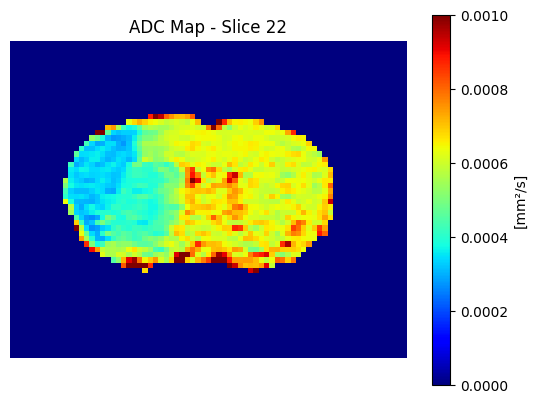

In [7]:
# Calculate ADC map
ADC_map = compute_adc(diff_img, bvals, brain_mask)

plt.imshow(ADC_map[:, :, 22], cmap='jet', vmin=0, vmax=0.001)
plt.colorbar(label='[mm²/s]')
plt.title("ADC Map - Slice 22")
plt.axis('off')
plt.show();

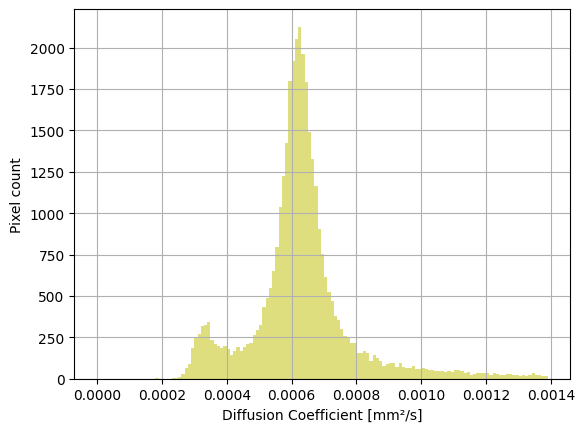

In [8]:
# Create ADC histogram
adc_vals = ADC_map[
    (ADC_map >= 0.00001) & (ADC_map <= 0.0014)]
plt.hist(adc_vals,
         bins = np.arange(0, 0.0014, 1e-5),
         color = 'y',
         alpha = 0.5)
plt.xlabel('Diffusion Coefficient [mm²/s]')
plt.ylabel('Pixel count')
plt.grid(True)
plt.show();

In [9]:
# Prepare data for training
X = ADC_map.flatten()
X = X[
    (X >= 0.0002) & (X <= 0.0014)]

X_mm = (X * 1e3).reshape(-1, 1) # [adc, 1]

# Initialize parameters
mu0 = np.array([[0.35], [0.6], [0.9]]) # mm2/s * 1e-3
w0 = np.array([0.2, 0.7, 0.1])
var0 = (np.array([0.05, 0.10, 0.10]) ** 2) # mm2/s * 1e-3

# Fitting GMM
gmm = GaussianMixture(
    n_components = 3,
    covariance_type = 'diag',
    means_init = mu0,
    weights_init = w0,
    reg_covar = 1e-6,
    max_iter = 500,
    random_state = 42)
gmm.fit(X_mm)

print(f'Means (mm2/s * 1e-3): {gmm.means_.ravel()}')
print(f'Variances: {gmm.covariances_.ravel()}')
print(f'Weights: {gmm.weights_}')

Means (mm2/s * 1e-3): [0.35435439 0.6217917  0.93098661]
Variances: [0.00217666 0.00469795 0.03889651]
Weights: [0.09862064 0.78813812 0.11324124]


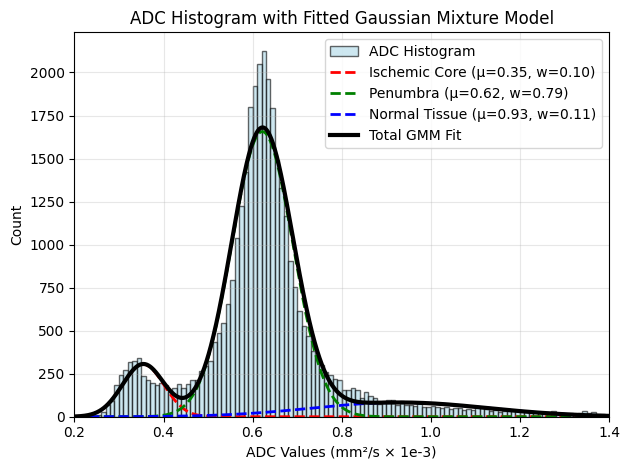

In [10]:
# Create histogram
adc_vals_plot = ADC_map[(ADC_map >= 0.0002) & (ADC_map <= 0.0014)]
counts, bins, patches = plt.hist(adc_vals_plot * 1e3, 
                                bins = np.arange(0.2, 1.4, 0.01),
                                density = False, 
                                alpha = 0.6, 
                                color = 'lightblue', 
                                edgecolor = 'black',
                                label = 'ADC Histogram')

# Create x values for smooth curves
x_range = np.linspace(0.2, 1.4, 1000)
x_range_reshaped = x_range.reshape(-1, 1)

# Plot individual Gaussian components
colors = ['red', 'green', 'blue']
component_names = ['Ischemic Core', 'Penumbra', 'Normal Tissue']

# Scale factor to convert from density to counts
total_samples = len(adc_vals_plot)
bin_width = 0.01  # width of each histogram bin

for i in range(gmm.n_components):
    # Individual component - scale to counts
    component_pdf = gmm.weights_[i] * norm.pdf(x_range, 
                                              gmm.means_[i, 0], 
                                              np.sqrt(gmm.covariances_[i, 0]))
    component_counts = component_pdf * total_samples * bin_width
    plt.plot(x_range, 
             component_counts, 
             color = colors[i], 
             linewidth = 2, 
             linestyle = '--',
             label = f'{component_names[i]} (μ={gmm.means_[i, 0]:.2f}, w={gmm.weights_[i]:.2f})')

# Plot total fitted GMM - scale to counts
total_pdf = np.exp(gmm.score_samples(x_range_reshaped))
total_counts = total_pdf * total_samples * bin_width
plt.plot(x_range, 
         total_counts, 
         color = 'black', 
         linewidth = 3, 
         label = 'Total GMM Fit')

plt.xlabel('ADC Values (mm²/s × 1e-3)')
plt.ylabel('Count')
plt.title('ADC Histogram with Fitted Gaussian Mixture Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0.2, 1.4)
plt.tight_layout()
plt.show();

In [11]:
# --- 1) Dane wejściowe ---

X_all_mm = (ADC_map * 1e3).reshape(-1, 1)
probs = gmm.predict_proba(X_all_mm)
ischemic_class = np.argmin(gmm.means_.ravel())

confidence = 0.7
max_class = np.argmax(probs, axis = 1)
mask_flat = (max_class == ischemic_class) & (probs[:, ischemic_class] > confidence)
ischemia_mask = mask_flat.reshape(ADC_map.shape)

ischemia_mask = remove_small_objects(ischemia_mask, min_size=100)   # voxele <100 out
ischemia_mask = binary_closing(ischemia_mask, footprint=ball(1))    # domknięcie drobnych dziur
b0 = diff_img[..., 0].astype(np.float32)
b0 /= (b0.max() + 1e-12)
mask_vis = ischemia_mask.astype(np.uint8)

# --- 2) Parametry przestrzenne ---
spacing = (0.267, 0.333, 0.5)   # (dx, dy, dz)
origin  = (0.0, 0.0, 0.0)
nx, ny, nz = b0.shape

# --- 3) Tworzenie UniformGrid (stara składnia) ---
grid = pv.StructuredGrid()
x = np.arange(0, nx * spacing[0], spacing[0])
y = np.arange(0, ny * spacing[1], spacing[1])
z = np.arange(0, nz * spacing[2], spacing[2])
xx, yy, zz = np.meshgrid(x, y, z, indexing="ij")
grid.points = np.c_[xx.ravel(order="F"), yy.ravel(order="F"), zz.ravel(order="F")]
grid.dimensions = (nx, ny, nz)
grid["intensity"] = b0.ravel(order="F")

# --- 4) Mask -> StructuredGrid ---
mask_grid = pv.StructuredGrid()
mask_grid.points = np.c_[xx.ravel(order="F"), yy.ravel(order="F"), zz.ravel(order="F")]
mask_grid.dimensions = (nx, ny, nz)
mask_grid["values"] = mask_vis.ravel(order="F")

contours = mask_grid.contour(isosurfaces=[0.5])

# --- 5) Wizualizacja ---
plotter = pv.Plotter(notebook=False, window_size=(1200, 800))
plotter.add_volume(
    grid,
    cmap="gray",
    opacity=[0.00, 0.05, 0.10, 0.20, 0.35, 0.50, 0.65, 0.75, 0.85, 1.00],
    shade=False,
    show_scalar_bar=False  # This removes the colorbar
)
plotter.add_mesh(contours, color="red", opacity=0.6, smooth_shading=True)
plotter.add_axes()
plotter.show()
